## Land Surface Temperature from Landsat 4, 5, 7, 8 and 9

### Goals
- retrieve the LST series from 1985 to today date for a given polygon
- calculate monthly zscores
- save extracted data as .csv
- save array as netcdf 

In [1]:
import sys
import subprocess
import pkg_resources

required = {'rasterstats','odc-ui'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
else:
    print(f'Required packages {required} already installed.')

import geopandas as gpd
import stackstac
import xarray as xr
import numpy as np
import rioxarray

Required packages {'odc-ui', 'rasterstats'} already installed.


In [2]:
from scipy.signal import savgol_filter
import pylab as plt


In [4]:
# #_____ perhaps _______ CREATE DASK CLUSTER 
# cluster = GatewayCluster()  

# client = cluster.get_client()

# cluster.adapt(minimum=4, maximum=24)
# print(cluster.dashboard_link)


In [5]:
sys.path.append('/home/jovyan/PlanetaryComputerExamples/CODE/pcgrits/')
#from grits import humanbytes, get_field, get_lims, get_mms, xr_rasterize, calculate_indices, zscore_dataset
from grits import *

In [6]:
#%% PROVISIONAL REGION OF INTEREST PICKER
path = '/home/jovyan/PlanetaryComputerExamples/vetorial/FAZENDAS/'
savenc = '/home/jovyan/PlanetaryComputerExamples/myout_nc/'

### Define analysis area

In [7]:
name = 'Uniguiri_'
datetime457 = '1985-01-01/2013-05-05'
lst = True
#indices = ['EVI', 'LAI', 'BSI']
extract = True
visualize = False

got bbox, lat_range, lon_range
    PID  area_ha    R   ID      SR     Re   Fi     TID  \
0  R8_4      6.4  R8_    4  100000  80000    4  180004   
1     F     10.6    F  NaN  100000  80000  901  180901   
2  R8_5      6.9  R8_    5  100000  80000    5  180005   
3     C      0.7    C  NaN  100000  80000  801  180801   
4  R8_1      6.7  R8_    1  100000  80000    1  180001   

                                            geometry  
0  MULTIPOLYGON (((-54.57526 -16.95986, -54.57705...  
1  MULTIPOLYGON (((-54.57224 -16.96252, -54.57131...  
2  MULTIPOLYGON (((-54.57705 -16.96167, -54.57526...  
3  MULTIPOLYGON (((-54.56787 -16.95268, -54.56744...  
4  MULTIPOLYGON (((-54.57109 -16.95544, -54.57249...  


<Axes: >

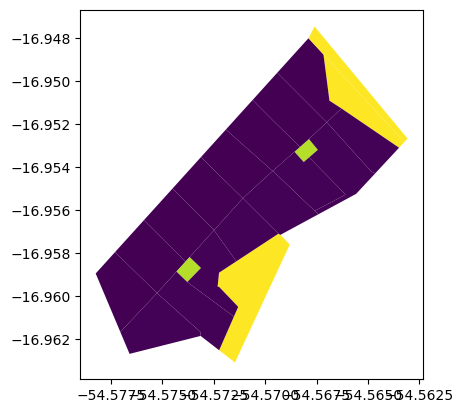

In [8]:
file = path + 'fazenda_uniguiri.gpkg'
layer = 'piquetes_tid'

# Get FIELD
field = gpd.read_file(file, layer=layer)
field = field[field['Re'] == 80000]

bbox, lat_range, lon_range = get_lims(field)
print(field.head())
field.plot(column='TID')

In [9]:
items = query_L457_items(datetime=datetime457,
                         bbox=bbox,
                         max_cloud=50,
                         landsats = ["landsat-4", "landsat-5", "landsat-7"]
                        )



 found 461 items 
 first: <Item id=LT05_L2SP_225072_19850218_02_T1> 
 last: <Item id=LE07_L2SP_225072_20130327_02_T1> 

dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'lwir', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'swir16', 'swir22', 'mtl.txt', 'mtl.xml', 'cloud_qa', 'mtl.json', 'qa_pixel', 'qa_radsat', 'atmos_opacity', 'tilejson', 'rendered_preview'])


In [10]:
assets = ['lwir']#,'qa']

datat = (
        stackstac.stack(
        items,
        assets=assets,
        bounds_latlon=bbox,
        epsg=4326, # o xarray de imagens será retornado no EPSG:4326
        resolution = 0.000281612818071153, # cuidado se for mexer na resolucao, tente algo como 0.001 para começar, pois é graus (não metros)
    ))
datat = datat.rename({'x': 'longitude','y': 'latitude'})

# to dataset
if visualize:
    dst_ = datat.to_dataset(dim='band')
dst = datat.to_dataset(dim='band') 
del dst.attrs['spec'] # spec deu problema pra salvar .nc


dst;

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/tmp/ipykernel_1881/2025099863.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ["landsat-8", "landsat-9"] in unique_platform:


In [11]:
print('Land Surface Temperature requested. \n -> Converting to Celcius')

# get lwir11 band info
band_info = items[0].assets["lwir"].extra_fields["raster:bands"][0]
print(band_info)

dst['lwir'] = dst['lwir'].astype(float)
dst['lwir'] *=band_info['scale']
dst['lwir'] +=band_info['offset']
dst['lwir'] -= 273.15

# variables to drop so I can save the .nc later on
drops = ['landsat:correction','landsat:wrs_path','landsat:wrs_row',
        'landsat:collection_number','landsat:wrs_type','instruments']

# interpolate NaNs (rechunk it first)
# XXX se a interpolacao ficar boa, usar jah lah apos o stackstac
dst = dst.chunk(dict(time=-1)) 
dst['lwir'] = xr.where(dst['lwir'] < 1, np.nan, dst['lwir']) # 
dst['lwir'] = xr.where(dst['lwir'] > 50, np.nan, dst['lwir'])
dst['lwir'] = dst['lwir'].interpolate_na(dim='time',method='linear')

# I`m overwriting the raw data
w = 5
dst['lwir'] = dst['lwir'].rolling(time=w, center=True).mean(savgol_filter, window = w, polyorder=2)


Land Surface Temperature requested. 
 -> Converting to Celcius
{'unit': 'kelvin', 'scale': 0.00341802, 'nodata': 0, 'offset': 149.0, 'data_type': 'uint16', 'spatial_resolution': 30}


In [12]:
print('Reprojecting and saving ... \n')
dst = dst.rio.write_crs('4326')
dst = dst.rio.reproject('EPSG:4326')
dst = dst.rename({'x': 'longitude','y': 'latitude'})
print('... saving ...')

dst.to_netcdf(f'{savenc}lst_{name}_457_bm_no_na.nc', mode='w')
print(f'lst_{name}.nc saved!')
dst;

Reprojecting and saving ... 



/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


... saving ...
lst_Uniguiri_.nc saved!


<xarray.Dataset>
Dimensions:                      (longitude: 54, latitude: 57, time: 461)
Coordinates: (12/24)
  * longitude                    (longitude) float64 -54.58 -54.58 ... -54.56
  * latitude                     (latitude) float64 -16.95 -16.95 ... -16.96
    landsat:collection_category  <U2 'T1'
    view:off_nadir               int64 0
    landsat:collection_number    <U2 '02'
    view:sun_azimuth             (time) float64 87.12 42.91 ... 70.57 60.32
    ...                           ...
    view:sun_elevation           (time) float64 50.56 35.92 ... 54.88 52.74
    epsg                         int64 4326
    landsat:scene_id             (time) <U21 'LT52250721985049CUB00' ... 'LE7...
  * time                         (time) datetime64[ns] 1985-02-18T13:10:17.02...
    platform                     (time) <U9 'landsat-5' ... 'landsat-7'
    spatial_ref                  int64 0
Data variables:
    lwir                         (time, latitude, longitude) float64 nan ... nan
    qa                           (time, latitude, longitude) float64 nan ... nan
Attributes:
    transform:   | 0.00, 0.00,-54.58|\n| 0.00,-0.00,-16.95|\n| 0.00, 0.00, 1.00|
    resolution:  0.000281612818071153

### Zscores

In [13]:
dst_mean = dst.groupby('time.month').mean(dim='time')
dst_std = dst.groupby('time.month').std(dim='time')

dst_anom = dst.groupby('time.month') - dst_mean
dst_z = dst_anom.groupby('time.month') / dst_std


In [14]:
print('Reprojecting and saving ... \n')
dst_z = dst_z.rio.write_crs('4326')
dst_z = dst_z.rio.reproject('EPSG:4326')
dst_z = dst_z.rename({'x': 'longitude','y': 'latitude'})

print('... saving zscores...')

dst_z.to_netcdf(f'{savenc}zlst_{name}_457bm_no_na.nc', mode='w')
print(f'zlst_{name}.nc saved!')

Reprojecting and saving ... 

... saving zscores...
zlst_Uniguiri_.nc saved!


#### Visualizing some series

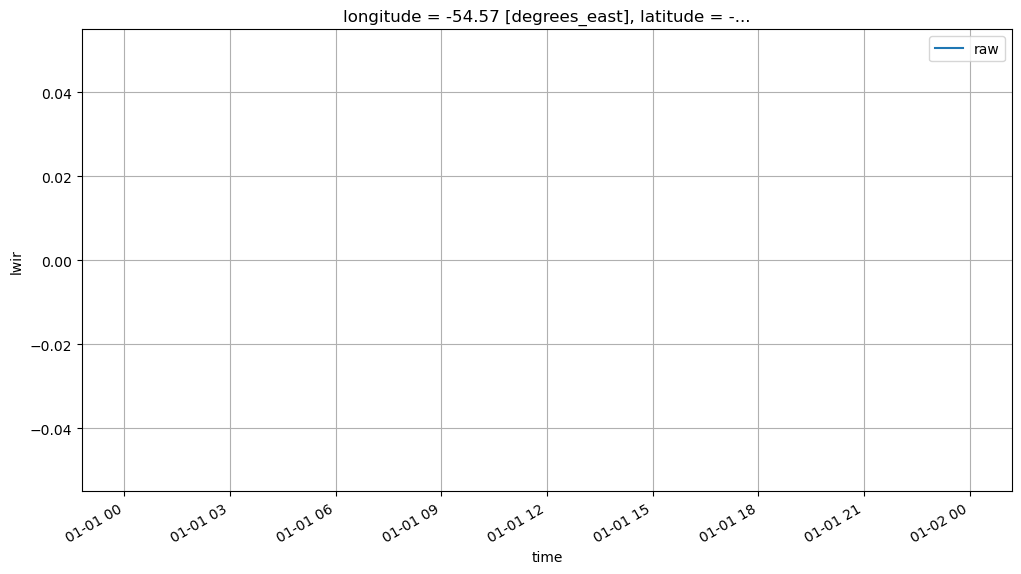

In [15]:
lat, lon = -16.95562, -54.57255 #pasto
#lat, lon = -16.96191, -54.56892 #floresta
di,df = '1990', '2012'

# plt.figure(figsize=(12,6))
# dst['lwir'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='raw')
# #dst['lwir_3'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='3')
# #dst['lwir_5'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='5')
# #dst['lwir_7'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='7')
# #dst['lwir_9'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='9')
# plt.legend()
# plt.grid()
# plt.show()
# plt.close()

########

plt.figure(figsize=(12,6))
dst_z['lwir'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='raw')
#dst['lwir_3'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='3')
#dst['lwir_5'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='5')
#dst['lwir_7'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='7')
#dst['lwir_9'].sel(latitude=lat, longitude=lon, method='nearest').loc[di:df].plot(label='9')
plt.legend()
plt.grid()
plt.show()
plt.close()